In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit
from convokit import TextParser, TensorDecomposer, Corpus, download
import pandas as pd
import numpy as np

In [3]:
corpus = Corpus(filename=download("reddit-coarse-discourse-corpus"))

Dataset already exists at /Users/calebchiam/.convokit/downloads/reddit-coarse-discourse-corpus


In [4]:
corpus.print_summary_stats()

Number of Speakers: 63573
Number of Utterances: 115827
Number of Conversations: 9483


In [5]:
full_convos = {c.id for c in corpus.iter_conversations() if c.check_integrity(verbose=False)}

In [6]:
corpus.filter_conversations_by(lambda convo: convo.id in full_convos)

In [7]:
corpus.print_summary_stats()

Number of Speakers: 62416
Number of Utterances: 113364
Number of Conversations: 9357


In [8]:
for utt in corpus.iter_utterances():
    utt.timestamp = 0

In [9]:
import random

In [10]:
longest_path_ids = []
for convo in corpus.iter_conversations():
    longest_path = random.choice(convo.get_longest_paths())
    convo.meta['longest_path'] = len(longest_path)
    longest_path_ids.extend([utt.id for utt in longest_path])

In [11]:
longest_path_ids = set(longest_path_ids)

In [12]:
corpus = corpus.filter_utterances_by(lambda utt: utt.id in longest_path_ids)

In [13]:
convo_df = corpus.get_conversations_dataframe()

In [14]:
import seaborn as sns

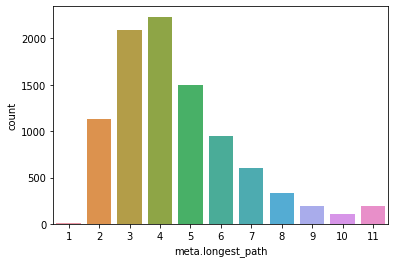

In [15]:
sns.countplot(convo_df['meta.longest_path'])

In [16]:
annotation_types = set()
for utt in corpus.iter_utterances():
    for t in utt.meta['annotation-types']:
        annotation_types.add(t)

In [17]:
annotation_types = sorted(list(annotation_types))
annotation_types

['agreement',
 'announcement',
 'answer',
 'appreciation',
 'disagreement',
 'elaboration',
 'humor',
 'negativereaction',
 'other',
 'question']

In [18]:
for utt in corpus.iter_utterances():
    utt.meta['annot-dict'] = {k: 0 for k in annotation_types}
    for t in annotation_types:
        utt.meta[t] = 0
    for t in utt.meta['annotation-types']:
        utt.meta['annot-dict'][t] = 1
        utt.meta[t] = 1

In [19]:
LENGTH = 8
min_length = lambda utt: utt.meta['valid']

In [20]:
for convo in corpus.iter_conversations():
    utts = convo.get_chronological_utterance_list()
    for utt_idx in range(len(utts) - LENGTH):
        subset = utts[utt_idx: utt_idx + LENGTH]
        start_utt = utts[utt_idx]
        for idx, utt in enumerate(subset):
            start_utt.meta['annot-dict-{}'.format(idx+1)] = utt.meta['annot-dict']
        start_utt.meta['valid'] = True

In [21]:
for utt in corpus.iter_utterances():
    if 'valid' not in utt.meta:
        utt.meta['valid'] = False

In [22]:
td = TensorDecomposer(feature_set=['annot-dict-{}'.format(idx) for idx in range(1, 8+1)], 
                      obj_type="utterance", tensor_func='tensortools-ncp-bcd', rank=20)

In [23]:
td.fit(corpus, selector=min_length)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.8453451633564655, improvement inf.
NCP_BCD: iteration 2, objective 0.8246405742530292, improvement 0.02070458910343631.
NCP_BCD: iteration 3, objective 0.8027902522727296, improvement 0.02185032198029957.
NCP_BCD: iteration 4, objective 0.776171758492534, improvement 0.02661849378019565.
NCP_BCD: iteration 5, objective 0.752905833551237, improvement 0.023265924941296978.
NCP_BCD: iteration 6, objective 0.7339935876501846, improvement 0.018912245901052338.
NCP_BCD: iteration 7, objective 0.717882662437044, improvement 0.016110925213140614.
NCP_BCD: iteration 8, objective 0.7027497285894997, improvement 0.015132933847544328.
NCP_BCD: iteration 9, objective 0.6877221439950896, improvement 0.015027584594410115.
NCP_BCD: iteration 10, objective 0.6723596127226831, improvement 0.015362531272406499.
NCP_BCD: iteration 11, objective 0.6578397367051204, improvement 0.01451987601756266.
NCP_BCD: iteration 12, obje

Directory already exists. Exiting summarize()


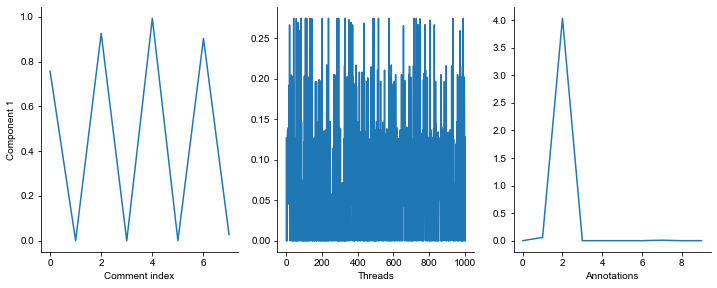

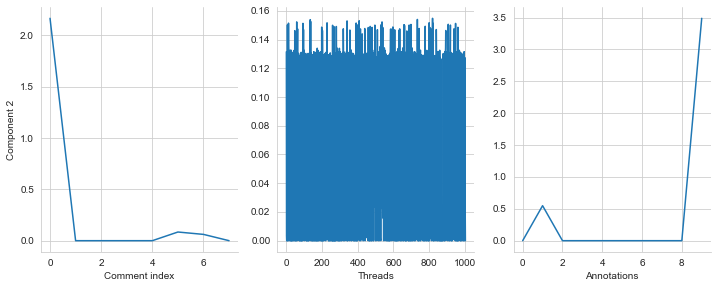

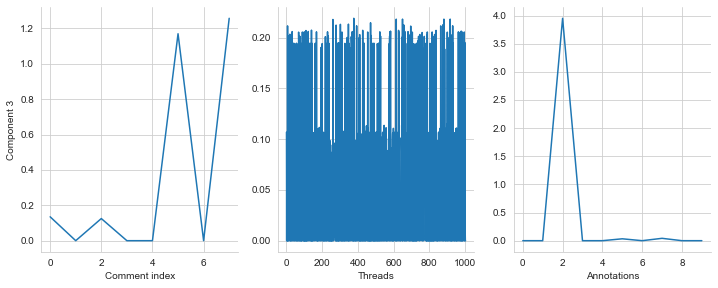

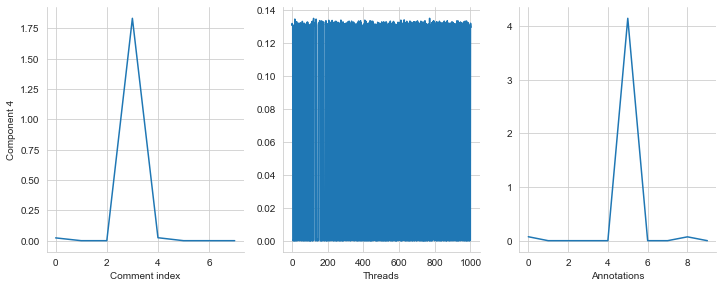

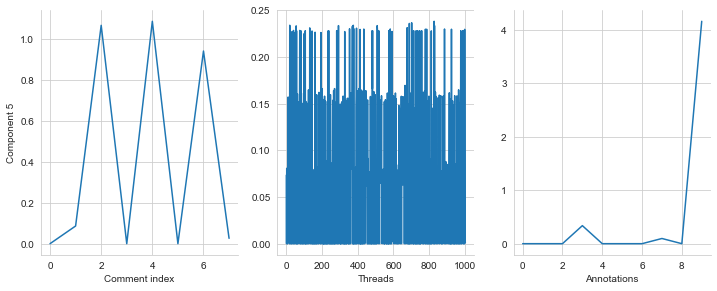

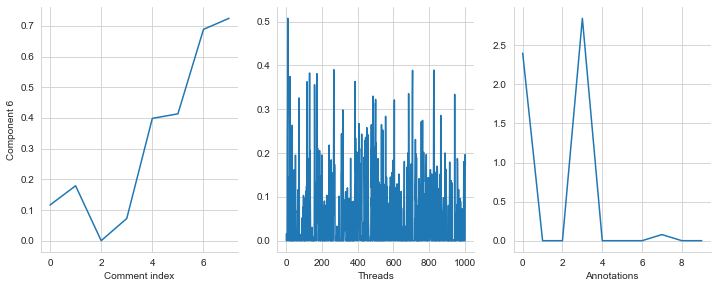

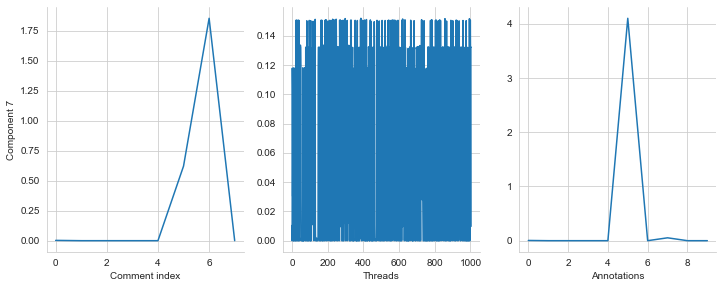

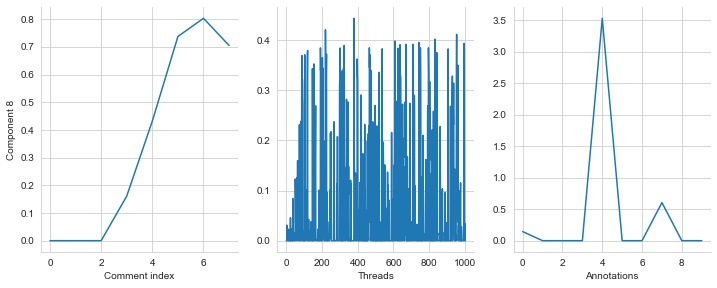

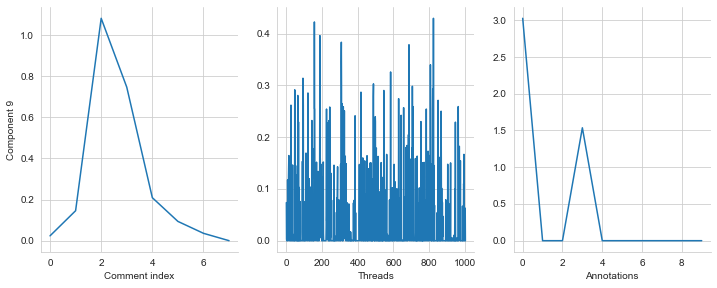

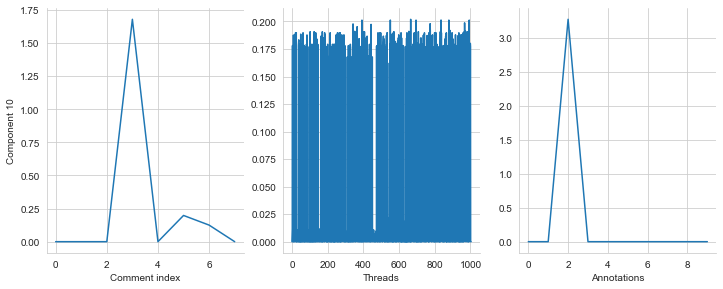

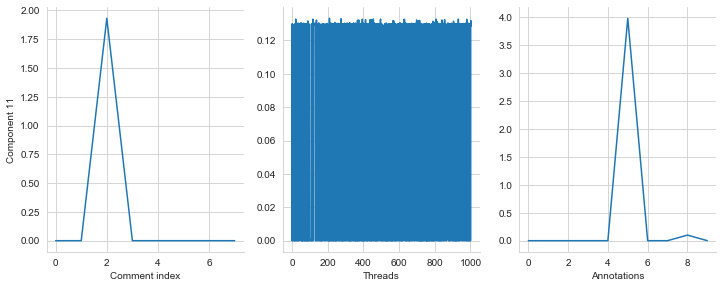

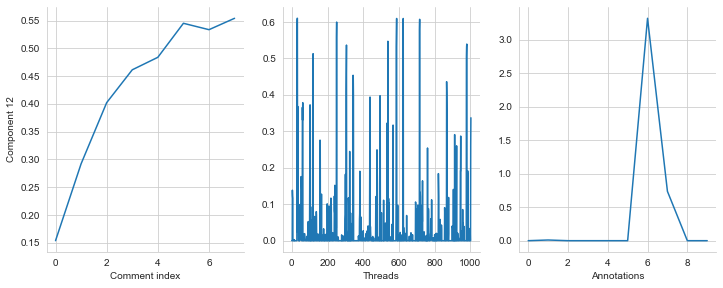

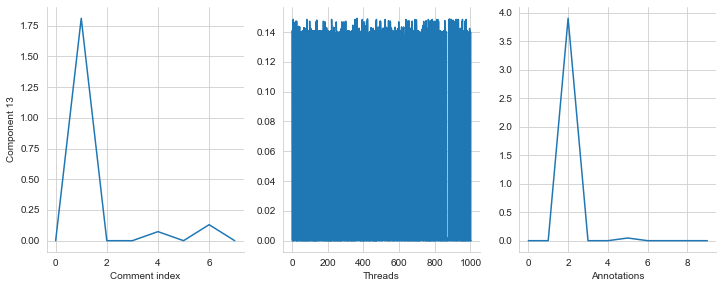

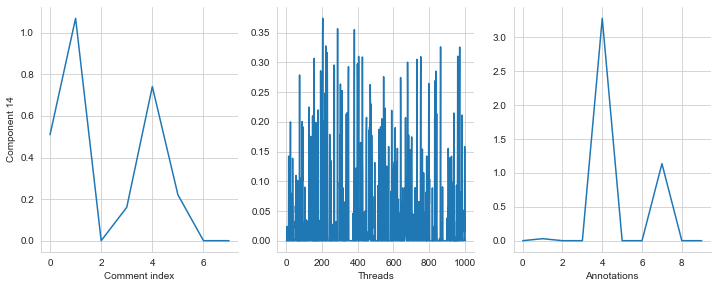

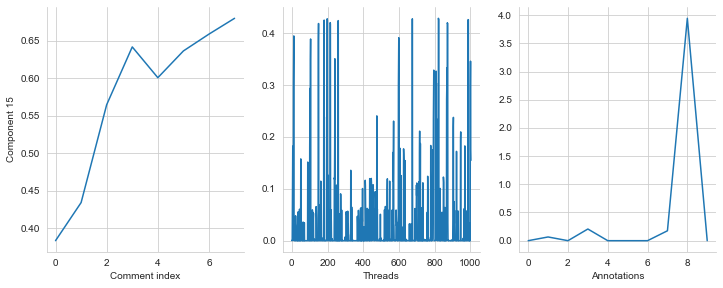

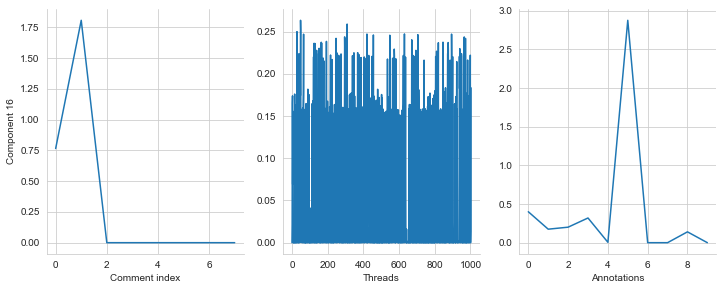

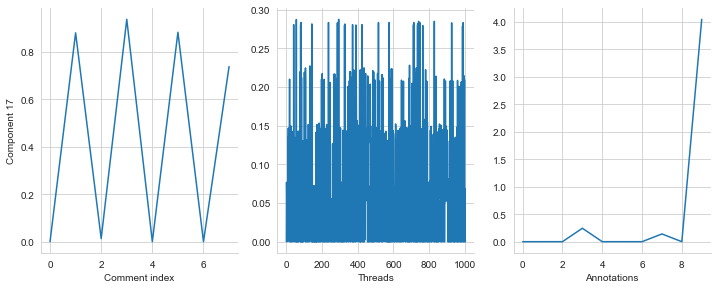

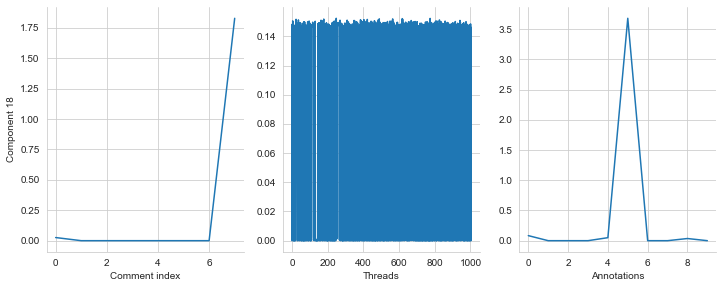

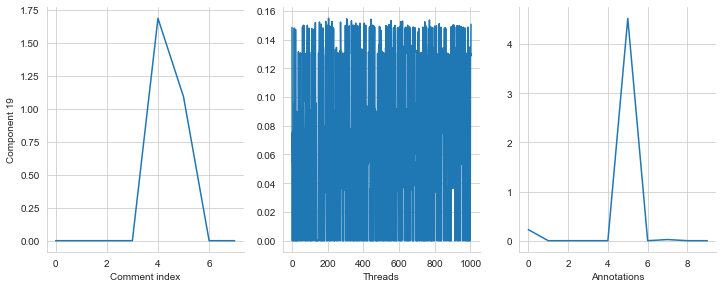

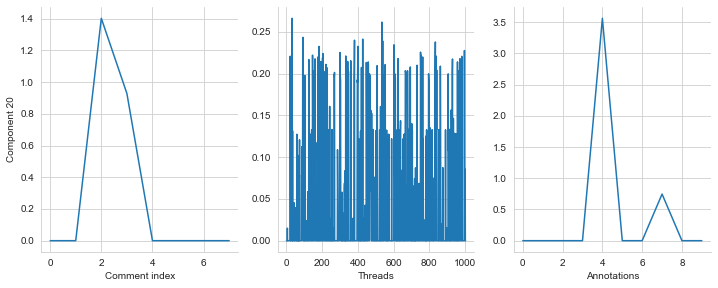

In [24]:
td.summarize(corpus, axis_names=['Comment index', 'Threads', 'Annotations'], 
             output_dir='convokit/tensor_decomposer/reports/coarse-discourse', 
             report_title='Coarse discourse', 
             liwc=True)

### Some breakdowns

In [26]:
td.factors[1].shape

(1004, 20)

In [37]:
thread_df = pd.DataFrame(td.factors[1].T)

In [34]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

def std_scale_df(df):
    d = dict()
    for i in range(df.shape[0]):
        d[i+1] = std_scaler.fit_transform(np.array(df.iloc[i]).reshape(-1, 1)).flatten()
    return pd.DataFrame.from_dict(d).T

In [35]:
def get_component_decomposition_nonnegative(V):
    feat_df = pd.DataFrame(V, index=list(range(1, V.shape[0]+1)), columns=list(range(1, V.shape[1]+1))).T
    retval = dict()
    for i in range(feat_df.shape[0]):
        s = sorted(list(feat_df.iloc[i].items()), key=lambda x: x[1], reverse=True)
        pos = [x[0] for x in s if x[1] >= 1]
        retval[i+1] = {'pos': pos}
    return retval

In [38]:
decomposed = get_component_decomposition_nonnegative(std_scale_df(thread_df).T)

In [39]:
print(decomposed[2]['pos'])

[819, 734, 134, 408, 340, 136, 58, 536, 800, 228, 391, 12, 821, 93, 948, 907, 698, 659, 6, 530, 397, 688, 919, 496, 259, 662, 778, 470, 280, 267, 390, 597, 198, 261, 803, 961, 480, 540, 459, 808, 744, 440, 439, 319, 939, 635, 63, 415, 584, 589, 96, 840, 510, 607, 742, 356, 631, 202, 893, 47, 804, 675, 406, 425, 13, 526]


In [34]:
for idx, utt in enumerate(corpus.iter_utterances(min_length)):
    if idx == 361:
        print(utt.id)
        break

t3_2sqie0


In [35]:
corpus.get_conversation('t3_2sqie0').print_conversation_structure(lambda utt: str(utt.meta['annotation-types']))

['question', 'question', 'question']
    ['answer', 'answer', 'answer']
        ['question', 'question', 'question']
            ['answer', 'answer', 'question']
                ['elaboration', 'elaboration', 'answer']
                    ['question', 'question', 'answer']
                        ['question', 'question', 'question']
                            ['answer', 'answer', 'answer']
                                ['elaboration', 'question', 'disagreement']
                                    ['elaboration', 'answer', 'elaboration']
                                        ['elaboration', 'question', 'elaboration']


In [36]:
td.factors[1][361]

array([0.13103319, 0.18216277, 0.        , 0.08911331, 0.        ,
       0.00690434, 0.22408212, 0.        , 0.        , 0.10364151,
       0.        , 0.        , 0.00039346, 0.        , 0.        ,
       0.09989245, 0.        , 0.        , 0.10268085, 0.        ])

In [37]:
np.array(std_scale_df(pd.DataFrame(td.factors[1]).T).T.iloc[361])

array([ 0.88943618,  1.16672651, -0.99743577,  1.10097879, -0.56936584,
       -0.66435461,  2.14806434, -0.50075355, -0.61873927,  0.57654364,
       -0.4610803 , -0.29559688, -0.72688607, -0.78995206, -0.95942148,
        0.47827628, -0.41514484, -1.05126803,  0.45013695, -1.02500993])

### TCA on Concat

In [25]:
concat_all = {}
for utt_idx, utt in enumerate(corpus.iter_utterances(selector=min_length)):
    concat = {}
    for idx in range(1, 8+1):
        for k, v in utt.meta['annot-dict-{}'.format(idx)].items():
            concat[k+str(idx)] = v
    concat_all[utt_idx] = concat

In [26]:
len(concat_all)

1004

In [27]:
# hack to make one convo hold the concatenated data
special_convo = corpus.random_conversation()

In [28]:
special_convo.meta['special'] = True
for k, v in concat_all.items():
    special_convo.meta['concat_{}'.format(k)] = v

In [29]:
td_concat = TensorDecomposer(feature_set=['concat_{}'.format(idx) for idx in range(1004)], 
                      obj_type="conversation", tensor_func='tensortools-ncp-bcd', rank=20)

In [40]:
td_concat.fit(corpus, selector=lambda convo: convo.meta.get('special', False) == True)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.8443791760381143, improvement inf.
NCP_BCD: iteration 2, objective 0.8342525637969315, improvement 0.01012661224118283.
NCP_BCD: iteration 3, objective 0.8292582007910697, improvement 0.004994363005861757.
NCP_BCD: iteration 4, objective 0.8207520465365068, improvement 0.008506154254562914.
NCP_BCD: iteration 5, objective 0.804403553314988, improvement 0.016348493221518767.
NCP_BCD: iteration 6, objective 0.7785264128638444, improvement 0.025877140451143643.
NCP_BCD: iteration 7, objective 0.7482628808872188, improvement 0.03026353197662557.
NCP_BCD: iteration 8, objective 0.7198751763050548, improvement 0.028387704582163997.
NCP_BCD: iteration 9, objective 0.6958262291393926, improvement 0.024048947165662193.
NCP_BCD: iteration 10, objective 0.6774587767155716, improvement 0.018367452423820985.
NCP_BCD: iteration 11, objective 0.6622939919902204, improvement 0.01516478472535121.
NCP_BCD: iteration 12, o

Directory already exists. Exiting summarize()


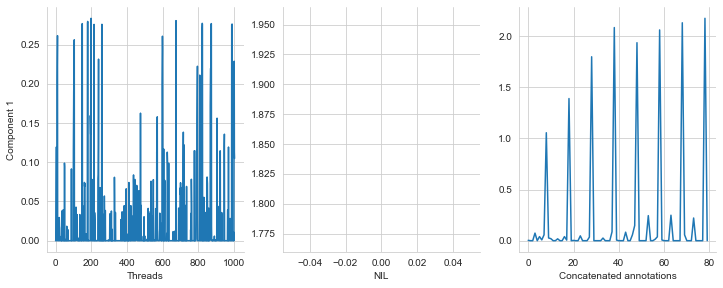

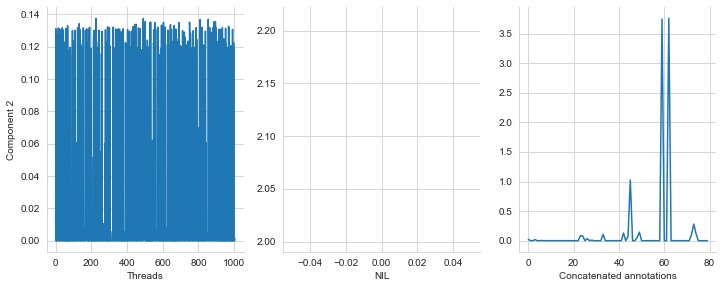

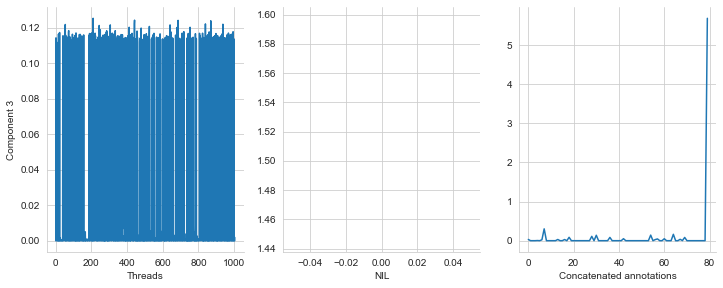

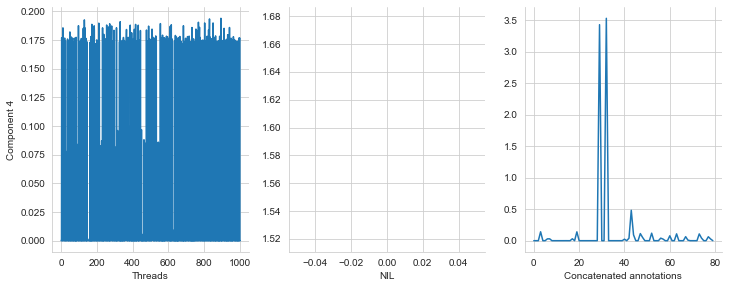

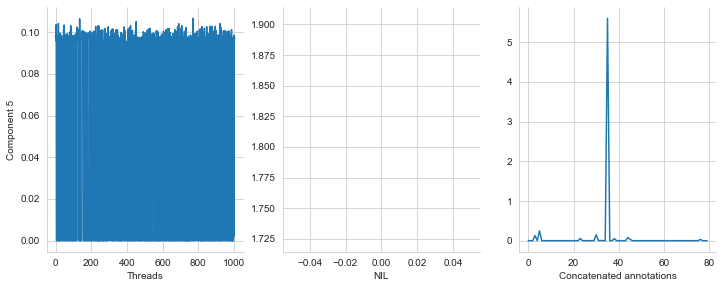

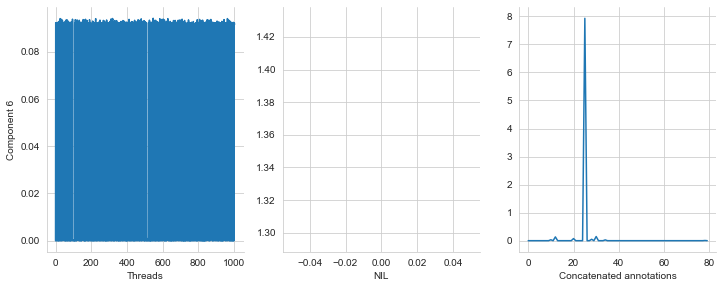

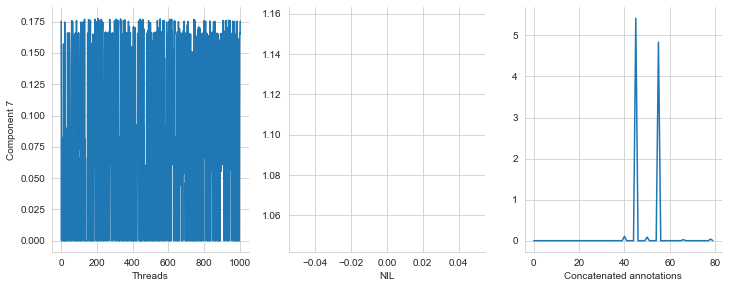

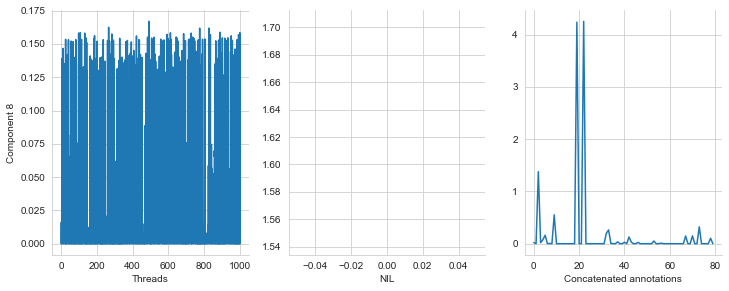

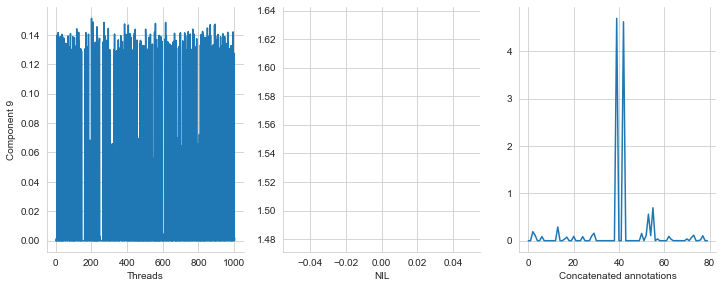

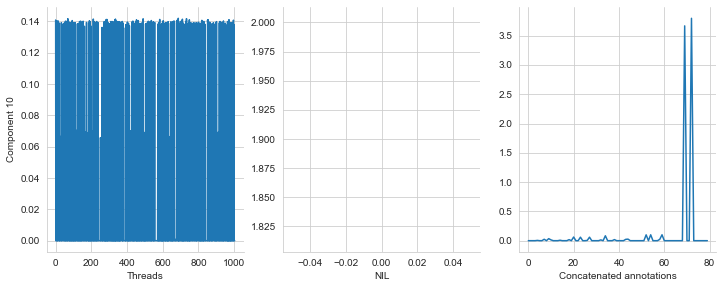

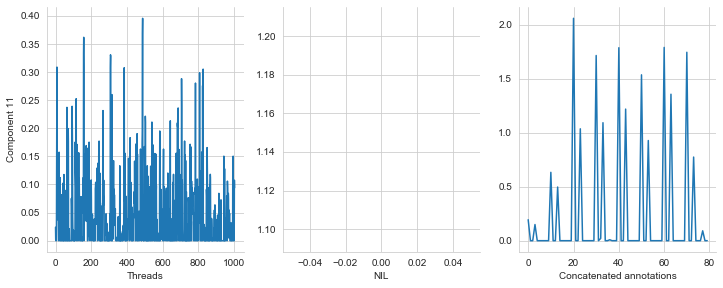

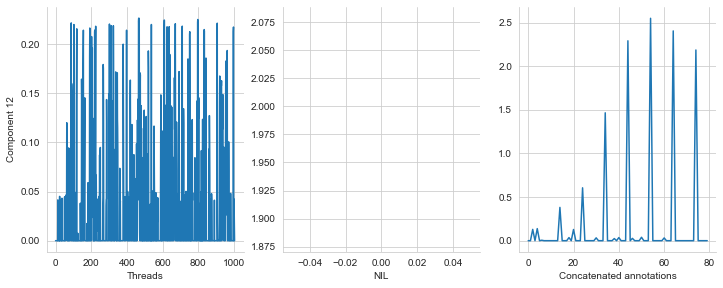

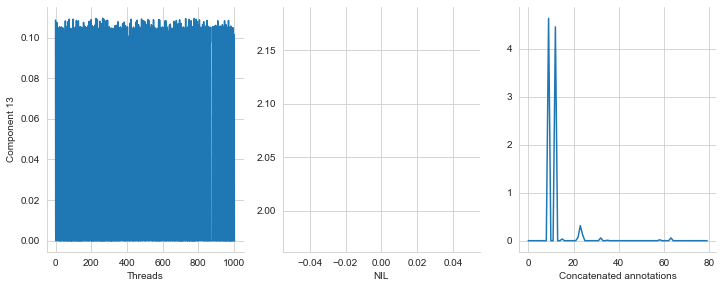

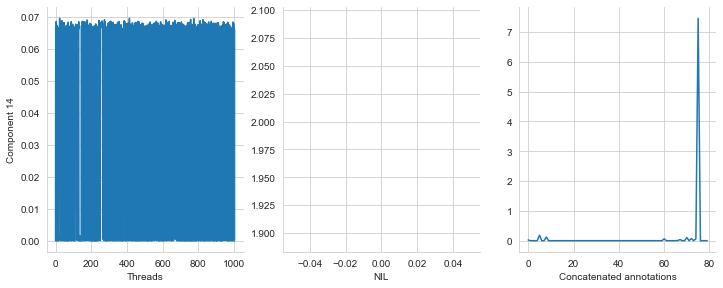

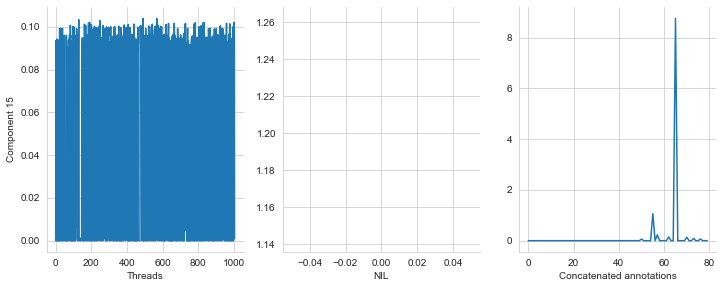

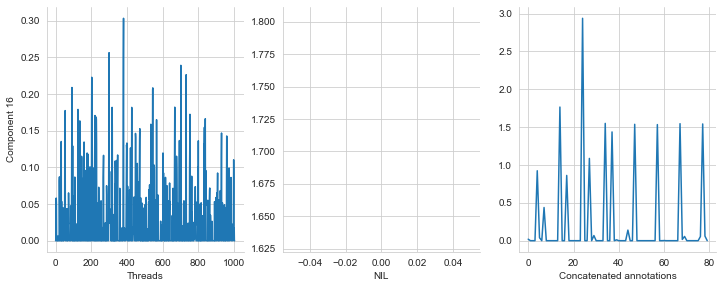

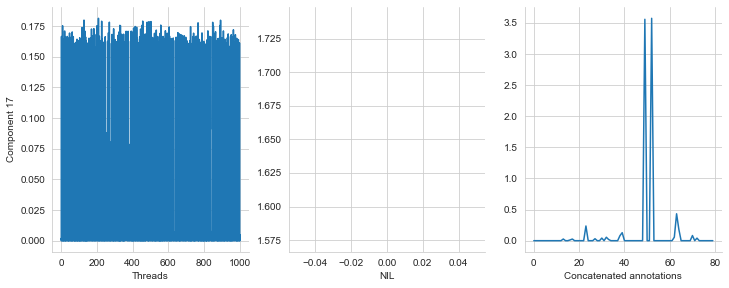

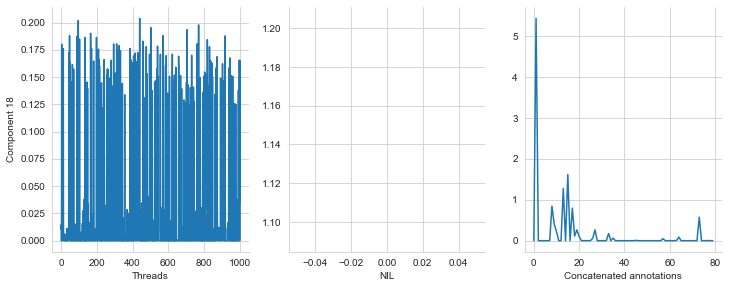

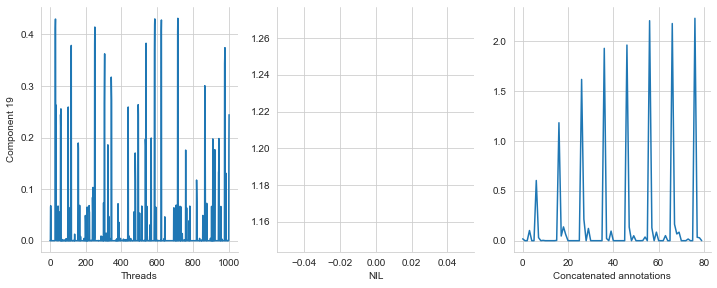

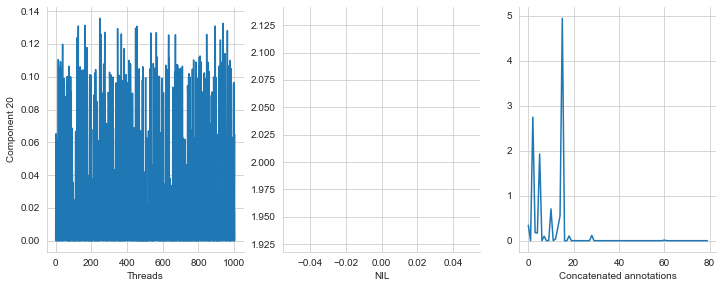

In [41]:
td_concat.summarize(corpus, axis_names=['Threads', 'NIL', 'Concatenated annotations'], 
             output_dir='convokit/tensor_decomposer/reports/coarse-discourse', 
             report_title='Coarse discourse', 
             liwc=True)

In [42]:
td_concat.factors[2].shape

(80, 20)

In [43]:
feat_df = pd.DataFrame(td_concat.factors[2].T)
std_scaled_df = std_scale_df(feat_df)

In [44]:
pd.set_option('display.max_columns', 500)
std_scaled_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
1,-0.358199,-0.364566,-0.364566,-0.231659,-0.364566,-0.292982,-0.350899,-0.261472,1.530397,-0.316568,-0.329089,-0.364566,-0.364566,-0.331957,-0.364566,-0.364566,-0.292866,-0.354327,2.130584,-0.364566,-0.360196,-0.364566,-0.364566,-0.279820,-0.364566,-0.364566,-0.364566,-0.302680,2.864170,-0.364566,-0.364566,-0.364566,-0.364566,-0.318636,-0.364566,-0.364566,-0.364566,-0.208293,3.376826,-0.354336,-0.364566,-0.364566,-0.364566,-0.215307,-0.364566,-0.364566,-0.261585,-0.098343,3.110953,-0.364566,-0.364566,-0.364566,-0.364566,0.075387,-0.364566,-0.364566,-0.339818,-0.296665,3.335060,-0.352069,-0.364566,-0.364566,-0.364566,0.082441,-0.364566,-0.364566,-0.364566,-0.364566,3.460869,-0.261731,-0.364566,-0.364566,-0.364566,0.033570,-0.364566,-0.364566,-0.364566,-0.364566,3.539286,-0.364566
2,-0.168021,-0.206240,-0.206240,-0.176198,-0.206240,-0.206240,-0.201594,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.062533,-0.071213,-0.206240,-0.147743,-0.206240,-0.191195,-0.206240,-0.206240,-0.206240,-0.206240,-0.026222,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,0.011955,-0.206240,-0.079130,1.522346,-0.206240,-0.206240,-0.117479,0.037737,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,6.102053,-0.206240,-0.206240,6.127631,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240,-0.037468,0.267138,-0.003155,-0.206240,-0.206240,-0.206240,-0.206240,-0.206240
3,-0.091472,-0.141030,-0.141030,-0.141030,-0.135275,-0.141030,-0.105455,0.338317,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.092040,-0.141030,-0.141030,-0.093909,-0.141030,-0.004079,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,0.034116,-0.141030,0.078264,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.008346,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.060691,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,0.084489,-0.141030,-0.097444,-0.069804,-0.141030,-0.141030,-0.062813,-0.141030,-0.141030,-0.141030,0.117012,-0.141030,-0.141030,-0.085262,-0.138005,-0.009237,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,-0.141030,8.863436
4,-0.202788,-0.202788,-0.202788,0.057591,-0.202788,-0.202788,-0.149104,-0.148781,-0.202788,-0.202788,-0.202788,-0.202788,-0.202788,-0.202788,-0.202461,-0.202788,-0.202788,-0.147424,-0.202788,0.055847,-0.202788,-0.202788,-0.202788,-0.202788,-0.202788,-0.202788,-0.202788,-0.202788,-0.202788,6.109501,-0.202788,-0.202788,6.296001,-0.202788,-0.202788,-0.202788,-0.202788,-0.202788,-0.202788,-0.202788,-0.159103,-0.202788,-0.129980,0.685300,-0.032465,-0.202788,-0.202788,0.004346,-0.108492,-0.202788,-0.202788,-0.202788,0.016452,-0.202788,-0.202788,-0.202788,-0.129024,-0.155278,-0.202788,-0.202788,-0.060365,-0.202788,-0.202788,-0.003282,-0.202788,-0.202788,-0.202788,-0.085477,-0.187379,-0.202788,-0.202788,-0.202788,-0.202788,-0.005102,-0.126915,-0.202788,-0.202788,-0.088078,-0.152990,-0.202788
5,-0.128127,-0.128127,-0.128127,0.081185,-0.128127,0.268810,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.041285,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,0.108461,-0.128127,-0.119504,-0.128127,-0.128127,8.873030,-0.128127,-0.128127,-0.045324,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.004795,-0.075339,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.128127,-0.

In [45]:
def get_component_decomposition_nonnegative(V):
    feat_df = pd.DataFrame(V, index=list(range(1, V.shape[0]+1)), columns=list(range(1, V.shape[1]+1))).T
    retval = dict()
    for i in range(feat_df.shape[0]):
        s = sorted(list(feat_df.iloc[i].items()), key=lambda x: x[1], reverse=True)
        pos = [x[0] for x in s if x[1] >= 1]
        retval[i+1] = {'pos': pos}
    return retval

In [46]:
decomposed = get_component_decomposition_nonnegative(std_scaled_df.T)

In [47]:
decomposed

{1: {'pos': [78, 68, 38, 58, 48, 28, 18, 8]},
 2: {'pos': [62, 59, 45]},
 3: {'pos': [79]},
 4: {'pos': [32, 29]},
 5: {'pos': [35]},
 6: {'pos': [25]},
 7: {'pos': [45, 55]},
 8: {'pos': [22, 19, 2]},
 9: {'pos': [39, 42]},
 10: {'pos': [72, 69]},
 11: {'pos': [20, 60, 40, 70, 30, 50, 63, 43, 33, 23, 53, 73]},
 12: {'pos': [54, 64, 44, 74, 34]},
 13: {'pos': [9, 12]},
 14: {'pos': [75]},
 15: {'pos': [65]},
 16: {'pos': [24, 14, 34, 67, 77, 47, 57, 37, 27, 4, 17]},
 17: {'pos': [52, 49]},
 18: {'pos': [1, 15, 13, 8]},
 19: {'pos': [76, 56, 66, 46, 36, 26, 16]},
 20: {'pos': [15, 2, 5]}}

In [48]:
from collections import defaultdict
def index_to_semantic(ls):
    retval = defaultdict(list)
    for idx in ls:
        comment_idx = idx // 10 + 1
        retval[idx_to_annot[idx % 10]].append(comment_idx)
    for k, v in retval.items():
        retval[k] = sorted(v)
    return retval

In [49]:
idx_to_annot = {idx: v for idx, v in enumerate(annotation_types)}

In [50]:
for component_idx in range(1, len(decomposed)+1):
    print("Component index: {}\n".format(component_idx))
    print("Positive:")
    print(dict(index_to_semantic(decomposed[component_idx]['pos'])))
    print("------------------------------\n")

Component index: 1

Positive:
{'other': [1, 2, 3, 4, 5, 6, 7, 8]}
------------------------------

Component index: 2

Positive:
{'answer': [7], 'question': [6], 'elaboration': [5]}
------------------------------

Component index: 3

Positive:
{'question': [8]}
------------------------------

Component index: 4

Positive:
{'answer': [4], 'question': [3]}
------------------------------

Component index: 5

Positive:
{'elaboration': [4]}
------------------------------

Component index: 6

Positive:
{'elaboration': [3]}
------------------------------

Component index: 7

Positive:
{'elaboration': [5, 6]}
------------------------------

Component index: 8

Positive:
{'answer': [1, 3], 'question': [2]}
------------------------------

Component index: 9

Positive:
{'question': [4], 'answer': [5]}
------------------------------

Component index: 10

Positive:
{'answer': [8], 'question': [7]}
------------------------------

Component index: 11

Positive:
{'agreement': [3, 4, 5, 6, 7, 8], 'appre

### Concrete example

In [51]:
td_concat.factors[0][361]

array([0.        , 0.06571267, 0.        , 0.17332072, 0.        ,
       0.        , 0.06823759, 0.        , 0.12746863, 0.13947129,
       0.        , 0.        , 0.10478726, 0.        , 0.        ,
       0.        , 0.07355135, 0.        , 0.        , 0.        ])

In [52]:
np.array(std_scale_df(pd.DataFrame(td_concat.factors[0]).T).T.iloc[361])

array([-0.40864119,  0.6178027 , -0.53613662,  1.6035558 , -0.99955389,
       -0.95738182, -0.14629351, -0.65694892,  1.65881533,  1.74693855,
       -0.69882884, -0.60271139,  1.11030357, -1.00510984, -0.97534947,
       -0.57885155,  0.3743105 , -0.49740628, -0.29407587, -0.80941925])

## Comparison: An SVD analysis

In [53]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [54]:
for convo in corpus.iter_conversations():
    utts = convo.get_chronological_utterance_list()
    for utt_idx in range(len(utts) - LENGTH):
        subset = utts[utt_idx: utt_idx + LENGTH]
        start_utt = utts[utt_idx]
        for idx, utt in enumerate(subset):
            start_utt.meta['annot-dict-{}'.format(idx+1)] = utt.meta['annot-dict']
        start_utt.meta['valid'] = True

In [55]:
for convo in corpus.iter_conversations():
    utts = convo.get_chronological_utterance_list()
    for utt_idx in range(len(utts) - LENGTH):
        subset = utts[utt_idx: utt_idx + LENGTH]
        start_utt = utts[utt_idx]
        start_utt.meta['concat'] = dict()
        for idx, utt in enumerate(subset):
            d = start_utt.meta['annot-dict-{}'.format(idx+1)].copy()
            start_utt.meta['concat'].update({k+"_"+str(idx): v for k, v in d.items()})

In [56]:
concat_vals = []
for utt in corpus.iter_utterances(lambda u: u.meta['valid']):
    concat_vals.append(list(utt.meta['concat'].values()))

In [66]:
svd = TruncatedSVD(n_components=20, random_state=42)
svd.fit(concat_vals)

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5, random_state=42,
             tol=0.0)

In [67]:
U, s, V = svd.transform(concat_vals) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

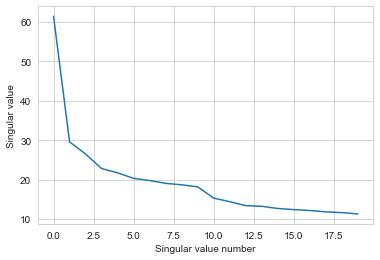

In [68]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s)
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [69]:
feat_df = pd.DataFrame(V.T)
std_scaled_df = std_scale_df(feat_df)

In [70]:
def get_component_decomposition(V):
    feat_df = pd.DataFrame(V, index=list(range(1, V.shape[0]+1)), columns=list(range(1, V.shape[1]+1))).T
    retval = dict()
    for i in range(feat_df.shape[0]):
        s = sorted(list(feat_df.iloc[i].items()), key=lambda x: x[1], reverse=True)
        neg = [x[0] for x in s if x[1] <= -1]
        pos = [x[0] for x in s if x[1] >= 1]
        retval[i+1] = {'neg': neg, 'pos': pos}
    return retval

In [71]:
decomposed = get_component_decomposition(std_scaled_df.T)

In [72]:
V.shape

(80, 20)

###########
1


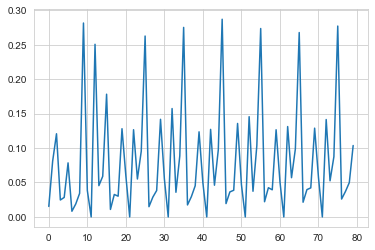

###########
2


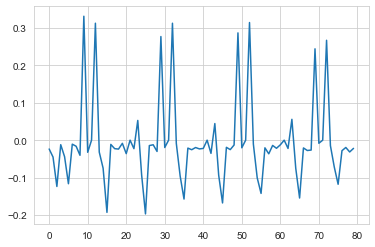

###########
3


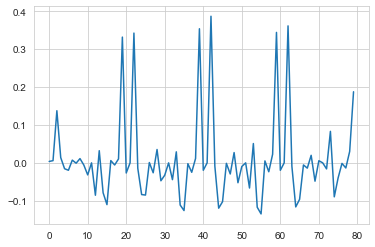

###########
4


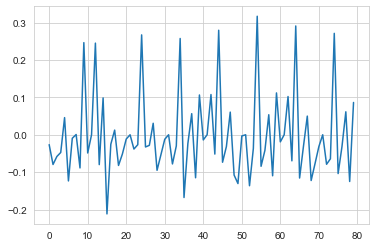

###########
5


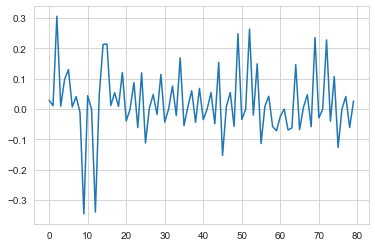

###########
6


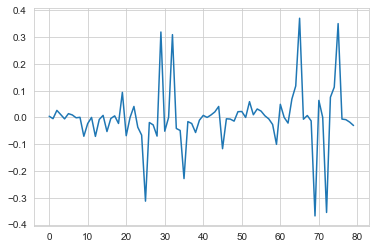

###########
7


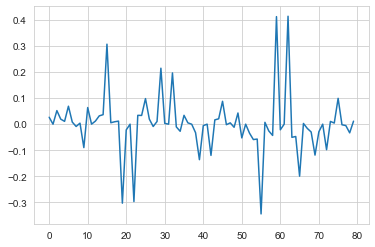

###########
8


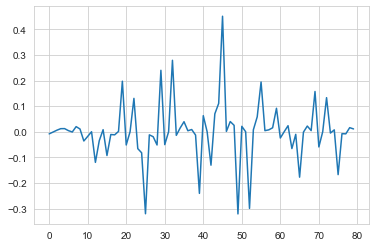

###########
9


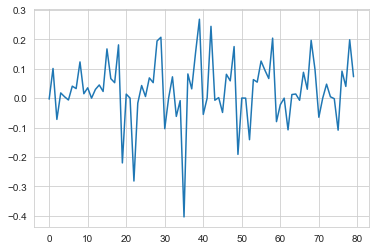

###########
10


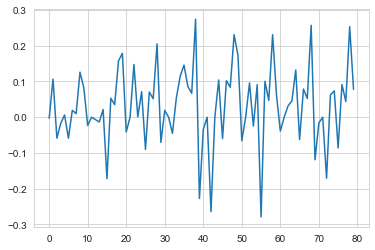

###########
11


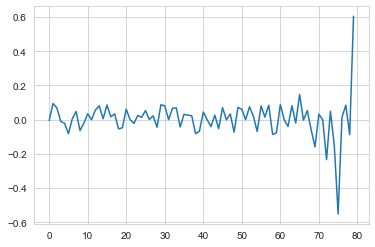

###########
12


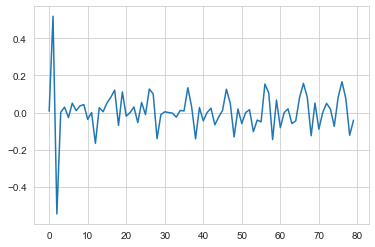

###########
13


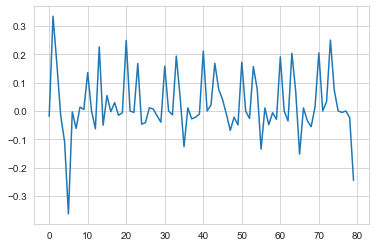

###########
14


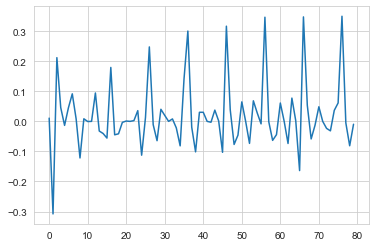

###########
15


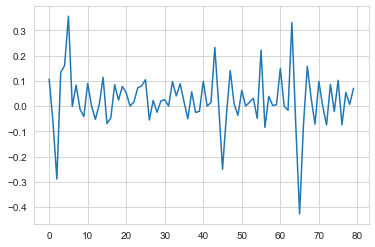

###########
16


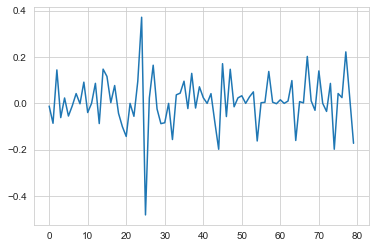

###########
17


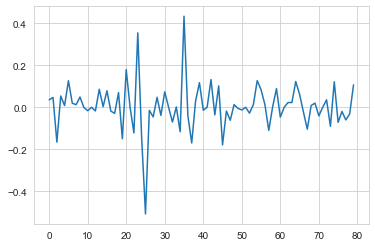

###########
18


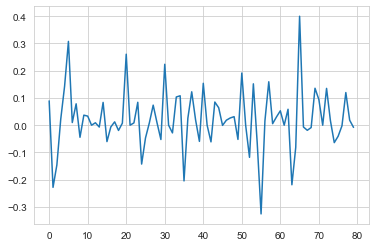

###########
19


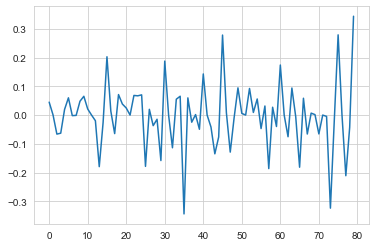

###########
20


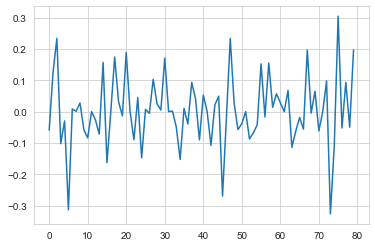

In [74]:
for component_idx in range(V.shape[1]):
    print('###########')
    print(component_idx + 1)
    sns.lineplot(data=V.T[component_idx])
    plt.show()

In [63]:
for component_idx in range(1, V.shape[1]+1):
    print("Component index: {}\n".format(component_idx))
    print("Positive:")
    print(dict(index_to_semantic(decomposed[component_idx]['pos'])))
    print("Negative:")
    print(dict(index_to_semantic(decomposed[component_idx]['neg'])))
    print("------------------------------\n")

Component index: 1

Positive:
{'elaboration': [2, 3, 4, 5, 6, 7, 8], 'question': [1], 'answer': [2]}
Negative:
{'announcement': [2, 3, 4, 5, 6, 7, 8]}
------------------------------

Component index: 2

Positive:
{'question': [1, 3, 5, 7], 'answer': [2, 4, 6, 8]}
Negative:
{'elaboration': [2, 3, 4, 5, 6, 7, 8], 'answer': [1]}
------------------------------

Component index: 3

Positive:
{'answer': [1, 3, 5, 7], 'question': [2, 4, 6, 8]}
Negative:
{'elaboration': [2, 4, 5, 6], 'disagreement': [4, 5, 6, 7]}
------------------------------

Component index: 4

Positive:
{'disagreement': [3, 4, 5, 6, 7, 8], 'question': [1, 6], 'answer': [2]}
Negative:
{'other': [4, 7, 8], 'elaboration': [1, 2, 4, 7], 'question': [5], 'answer': [6]}
------------------------------

Component index: 5

Positive:
{'answer': [1, 6, 8], 'question': [5, 7], 'elaboration': [2], 'disagreement': [2, 4, 5, 6, 7]}
Negative:
{'elaboration': [3, 5, 6, 8], 'answer': [2], 'question': [1]}
------------------------------

Co

### Thread analysis

In [70]:
U[361]

array([ 0.03104547,  0.06196266,  0.02427895,  0.01506737,  0.00466844,
       -0.01110637,  0.01548375,  0.02877069,  0.04869065, -0.02789323,
       -0.01413211,  0.00616449, -0.00012927, -0.01256193, -0.03242617,
        0.00458592,  0.00106561,  0.00276971, -0.0039869 , -0.03766851,
        0.03410018,  0.02490417,  0.02805014,  0.03815956,  0.00083192,
        0.00291376,  0.00196108, -0.01538602,  0.01865942, -0.00211809,
       -0.02771009,  0.00263928,  0.00811305,  0.01986447,  0.01356562,
       -0.01357293,  0.00584322,  0.00055776,  0.00784432, -0.03554553])

In [71]:
np.array(std_scale_df(pd.DataFrame(U).T).T.iloc[361])

array([ 0.04906858,  1.93262121,  0.69123421,  0.47403847,  0.06792313,
       -0.34433098,  0.46824093,  0.91071666,  1.50569205, -0.95518864,
       -0.47295855,  0.18027419, -0.01924669, -0.44989992, -1.05285468,
        0.13226646,  0.03378806,  0.05990847, -0.12729599, -1.18596662,
        1.07762771,  0.79662496,  0.88431791,  1.21237743,  0.01980306,
        0.09440537,  0.05012231, -0.49123757,  0.59196355, -0.06263591,
       -0.88114498,  0.08303516,  0.2589232 ,  0.62353339,  0.42452562,
       -0.42826671,  0.19730683, -0.00270914,  0.25652598, -1.11981527])

### Sanity-checking

In [72]:
from collections import defaultdict
announcement_occurrences = defaultdict(int)
for convo in corpus.iter_conversations():
    for idx, utt in enumerate(convo.get_chronological_utterance_list()):
        if 'announcement' in utt.meta['annotation-types']:
            announcement_occurrences[idx] += 1
        

In [73]:
announcement_occurrences

defaultdict(int, {0: 2650, 1: 1})

In [74]:
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

In [ ]:
concat_vals = np.array(concat_vals)

In [ ]:
for convo in corpus.iter_conversations():
    
    convo.meta['concat'] = dict()
    for idx in range(1, 6+1):
        d = convo.meta['annot-dict-{}'.format(idx)].copy()
        convo.meta['concat'].update({k+"_"+str(idx): v for k, v in d.items()})

In [ ]:
u, s, vh = np.linalg.svd(a, full_matrices=True)

In [ ]:
components = td.get_components(corpus, selector=lambda convo: convo.meta['longest_path'] >= 8)

In [ ]:
td.thread_anomaly_threshold = 1.5

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

In [ ]:
td.get_component_example(components, 1)

In [ ]:
components[7]['pos_feats']

In [ ]:
td.get_component_example(components, 8)

In [ ]:
td.get_component_example(components, 7)

In [ ]:
corpus.get_conversation('t3_29dtve').get_utterances_dataframe()[['text', 'speaker', 'meta.majority_type']]

In [ ]:
td.get_component_example(components, 3)

In [ ]:
td.get_component_example(components, 2)

In [ ]:
corpus.get_utterance('t1_d15lqk1').meta

In [ ]:
td.get_component_example(components, 4)

In [ ]:
td.get_component_example(components, 9)

In [ ]:
corpus.get_utterance('t1_c5j5t6r').meta['majority_type']

In [ ]:
td.get_component_example(components, 9)

In [ ]:
corpus.get_utterance('t1_c6hjgqv').meta

In [ ]:
td.get_component_example(components, 9)

In [ ]:
corpus.get_utterance('t1_d2o7juz').meta

In [ ]:
from collections import Counter

In [ ]:
dis_8 = 0
for convo_id in convo_df[convo_df['meta.longest_path'] >= 11].index:
    convo = corpus.get_conversation(convo_id)
    if convo.get_chronological_utterance_list()[9].meta['disagreement'] == 1:
        dis_8 += 1

In [ ]:
dis_8

In [ ]:
annotation_types